# BLR transfer example

Welcome to this example/tutorial notebook that will go through the fitting and evaluation of BLR models. 

### Imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pcntoolkit.dataio.norm_data import NormData
from pcntoolkit.normative_model.norm_conf import NormConf
from pcntoolkit.normative_model.norm_blr import NormBLR
from pcntoolkit.normative_model.norm_factory import load_normative_model
from pcntoolkit.normative_model.norm_factory import create_normative_model
from pcntoolkit.regression_model.blr.blr_conf import BLRConf
from pcntoolkit.regression_model.blr.blr import BLR
from pcntoolkit.util.plotter import plot_centiles, plot_qq
import seaborn as sns
import arviz as az

# Load data

First we download a small example dataset from github. Saving this dataset on your local device (under 'resources/data/fcon1000.csv' for example) saves time and bandwidth if you re-run this notebook.

First we download a small example dataset from github. Saving this dataset on your local device (under 'resources/data/fcon1000.csv' for example) saves time and bandwidth if you re-run this notebook.

In [7]:
# If you are running this notebook for the first time, you need to download the dataset from github.
# If you have already downloaded the dataset, you can comment out the following line
pd.read_csv(
    "https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/refs/heads/main/data/fcon1000.csv"
).to_csv("resources/data/fcon1000.csv", index=False)

In [8]:
data = pd.read_csv("resources/data/fcon1000.csv")

Plot the distribution of sex and site in the data.

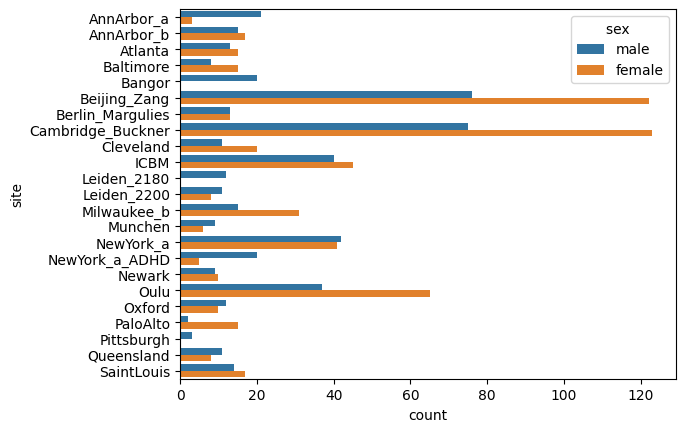

In [9]:
data["sex "] = np.where(data["sex"] == 1, ["male"], ["female"])
sns.countplot(data=data, y="site", hue="sex ", orient="v")
plt.show()

Our HBR models will use random effects to model differences between sites. Because the random effects are best captured when there are enough samples of each effect in the data, we will have to remove some sites that are too small. We will filter out sites for which any of the sexes is represented by less than 10 samples

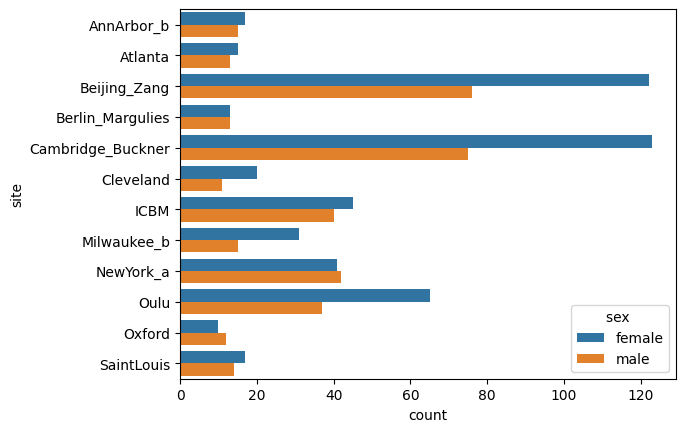

In [10]:
site_counts = data.groupby(["site", "sex"]).size().reset_index(name="counts")  # type: ignore
sex_count_per_site = site_counts["site"].value_counts()
sites_with_one_sex = sex_count_per_site[sex_count_per_site == 1]
sites_with_one_sex.index
data = data[~data["site"].isin(sites_with_one_sex.index)]
site_counts = site_counts[site_counts["counts"] < 10]
data = data[~data["site"].isin(site_counts["site"])]
sns.countplot(data=data, y="site", hue="sex ", orient="v")
plt.show()


Now we load the data into a `NormData` object. 

In [11]:
covariates = ["age"]
batch_effects = ["sex", "site"]
response_vars = ["rh_MeanThickness_thickness", "WM-hypointensities"]
norm_data = NormData.from_dataframe(
    name="full",
    dataframe=data,
    covariates=["age"],
    batch_effects=["sex", "site"],
    response_vars=["rh_MeanThickness_thickness", "WM-hypointensities"],
)

We will use 2 sites for transfer (Milwaukee and Oulu) and the rest for training.

In [12]:
transfer_sites = ["Milwaukee_b", "Oulu"]
transfer_data, fit_data = norm_data.split_batch_effects(
    {"site": transfer_sites}, names=["transfer", "fit"]
)


We also split the data into train and test sets.

In [13]:
train, test = fit_data.train_test_split()
transfer_train, transfer_test = transfer_data.train_test_split()

## Configure the normative model

The normative model will be configured using a `NormConf` object, containing save and log paths and the preprocessing configurations, and a `RegConf` object, specific to the regression model type. Our `NormConf` configuration contains canonical paths, a standardization step for both the input as as the output data, and a Bspline basis expansion.

In [14]:
# Create a NormConf object
norm_conf = NormConf(
    savemodel=True,
    saveresults=True,
    save_dir="resources/blr/save_dir",
    inscaler="standardize",
    outscaler="standardize",
    basis_function="linear",
    basis_function_kwargs={"order": 3, "nknots": 5},
)

Configuration of normative model is valid.


/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/normative_model/norm_conf.py:166: UserWarning: save_dir (resources/blr/save_dir) does not exist, creating it for you
  warnings.warn(


## Configure the regression model

BLR models are configured using a `BLRConf` object. 

In [15]:
blr_conf = BLRConf(
    optimizer="l-bfgs-b",
    n_iter=1000,
    heteroskedastic=True,
    random_intercept=True,
    random_intercept_var=True,
    warp="WarpSinhArcsinh",
    warp_reparam=True,
)

Configuration of regression model is valid.


## Combine normative and hbr conf in normative model
We can either use the NormHBR constructor, or the factory method to create a normative HBR model

In [16]:
# Using the constructor
norm_blr = NormBLR(norm_conf=norm_conf, reg_conf=blr_conf)
display(norm_blr)
del norm_blr

In [17]:
# Using the factory method
norm_blr = create_normative_model(norm_conf, blr_conf)
norm_blr

## Fit the model
With all our configuration done, we can fit our model on the train data. 

In [18]:
predictions = norm_blr.fit_predict(train, test)

Going to fit and predict 2 models
Fitting and predicting model for rh_MeanThickness_thickness
Fitting and predicting model for WM-hypointensities


/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=2.44839e-19): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=1.17917e-19): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:615: RuntimeWarning: overflow encountered in divide
  J_transposed[i] = df / dx
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=1.78409e-19): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolk

52495 Saving model to resources/blr/save_dir
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/model
Computing zscores for rh_MeanThickness_thickness
Computing zscores for WM-hypointensities
Computing centiles for rh_MeanThickness_thickness
Computing centiles for WM-hypointensities
Computing centiles for rh_MeanThickness_thickness
Computing centiles for WM-hypointensities
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/plots


As we can see, the model is saved to the save_dir specified in the norm_conf. We can inspect that folder to find three subfolders:
- `model`: contains the model and metadata
- `results`: containing csv files with the evaluation results for all response variables
- `plots`: containing qq plots and centile plots for each response variable

## Inspecting the model 

The norm_blr model contains a collection of regression models, one for each response variable. We can inspect those models individually by calling `norm_blr.regression_models.get("{responsevar}")`

In [19]:
model = norm_blr.regression_models.get("rh_MeanThickness_thickness")  # type: ignore
model.__dict__

{'_name': 'rh_MeanThickness_thickness',
 '_reg_conf': BLRConf(n_iter=1000, tol=1e-05, ard=False, optimizer='l-bfgs-b', l_bfgs_b_l=0.1, l_bfgs_b_epsilon=0.1, l_bfgs_b_norm='l2', intercept=False, random_intercept=True, heteroskedastic=True, intercept_var=False, random_intercept_var=True, warp='WarpSinhArcsinh', warp_reparam=True),
 'is_fitted': True,
 '_is_from_dict': False,
 'hyp': array([-2.78599356e-01,  3.22730233e-01,  3.04408161e-01,  2.34654494e-02,
         3.79355383e-02,  1.72680736e-01,  1.05641538e-01,  2.79417251e-01,
         2.93955233e-03, -7.72369346e-02,  3.88490993e-02,  3.71483464e-02,
         3.25272584e-03, -3.35773387e-01, -5.79785454e-02,  3.38888745e-03,
         6.05536216e-03,  6.19836484e-03,  4.09241678e-03,  2.52462313e-04,
         5.95010190e-03,  4.16961741e-03,  4.70213507e-03,  5.59332395e-03,
         3.34792815e-04,  5.60271258e-03,  5.83548649e-03,  3.11181025e-03]),
 'nlZ': 724.281541066589,
 'N': 587,
 'D': 13,
 'lambda_n_vec': array([2.14856718, 

## Evaluation
Calling `predict` will extend the predict_data object with a number of useful arrays.
1. `measures`: DataArray, which contains a number of evaluation statistics. 
1. `zscores`: the predicted z-scores for each datapoint.  
1. `centiles`: the predicted centiles of variation evaluated at each covariate in the dataset. 


In [20]:
display(test.measures.to_pandas().T)


response_vars,rh_MeanThickness_thickness,WM-hypointensities
statistics,,
Rho,0.488602,0.481607
RMSE,0.076973,480.699755
SMSE,0.609061,0.708531
ExpV,0.392441,0.304797
NLL,NaN,NaN
ShapiroW,0.982757,0.993043


Datasets with a zscores DataArray will have the `.plot_qq()` function available:

In [21]:
display(test.zscores.to_pandas())  # the zscores

response_vars,rh_MeanThickness_thickness,WM-hypointensities
datapoints,,
124,0.627941,1.421122
48,-0.293535,-0.955980
545,0.803795,0.455430
847,0.883346,0.578420
360,-2.703394,-0.448298
...,...,...
688,-1.417441,0.279008
420,1.093834,1.851164
123,-0.859754,-1.535225


In [22]:
display(test.centiles.to_dataframe().unstack(level=["response_vars", "cdf"]))

centiles                     \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.05               0.05   
datapoints                                                    
124                             2.384529         652.198246   
48                              2.323271         532.100915   
545                             2.257507         135.224616   
847                             2.355805         601.352992   
360                             2.382613         961.219568   
...                                  ...                ...   
688                             2.349431         554.523329   
420                             2.395714         884.395792   
123                             2.406316         726.237725   
276                             2.418482         216.391131   
183                             2.394593         656.842126   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.25               0.25   
datapoints                                                    
124                             2.440999         857.764843   
48                              2.383816         751.476434   
545                             2.352306         791.766246   
847                             2.422310         897.804946   
360                             2.436552        1177.733724   
...                                  ...                ...   
688                             2.417283         852.868678   
420                             2.446817        1044.760977   
123                             2.463503         952.392908   
276                             2.485762         489.580908   
183                             2.450350         852.366550   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.50               0.50   
datapoints                                                    
124                             2.483134        1008.603455   
48                              2.426619         910.039526   
545                             2.418759        1323.367031   
847                             2.471170        1123.162839   
360                             2.476423        1349.642197   
...                                  ...                ...   
688                             2.466868        1076.979655   
420                             2.484990        1164.662427   
123                             2.507790        1122.738533   
276                             2.540903         681.590030   
183                             2.492511         995.324985   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.75               0.75   
datapoints                                                    
124                             2.531015        1171.661356   
48                              2.471701        1078.786810   
545                             2.490367        2330.581760   
847                             2.526916        1387.115189   
360                             2.521086        1553.126935   
...                                  ...                ...   
688                             2.523171        1335.246325   
420                             2.527926        1295.430184   
123                             2.559243        1314.042092   
276                             2.606089         880.097595   
183                             2.540835        1148.811794   

                                                             
response_vars rh_MeanThickness_thickness WM-hypointensities  
cdf                                 0.95               0.95  
datapoints                                                   


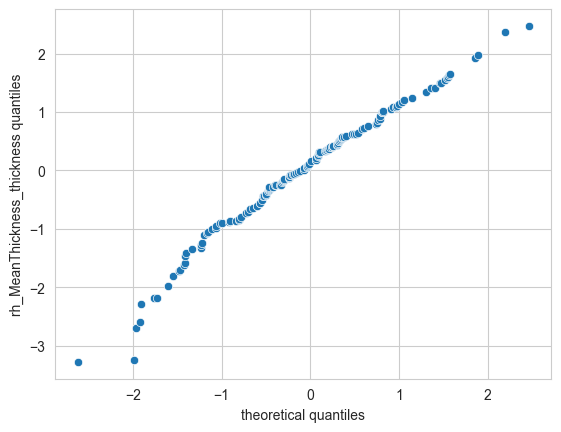

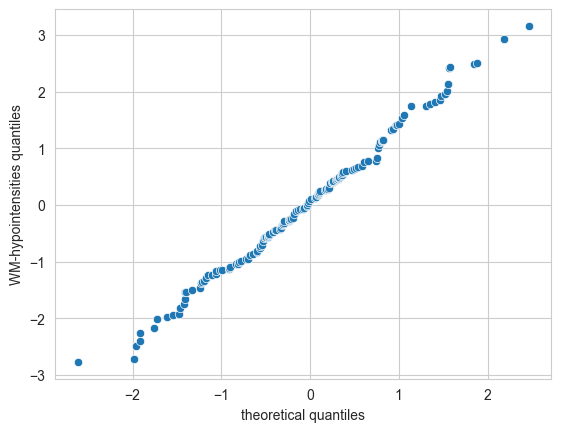

In [23]:
plot_qq(test)

And `plot_centiles()` can be called as a function of the model. A synthetic dataset is created internally, so we need to pass the original dataset (`train` in this case) as a template. We also need to pass which covariate is to be plotted on the x-axis, and the batch-effects for which the centiles are to be plotted. 

The lines correspond to the CDF values of: [0.05, 0.25, 0.5, 0.75, 0.95]. It is also possible to pass a list of CDF values to plot.

Computing centiles for rh_MeanThickness_thickness
Computing centiles for WM-hypointensities


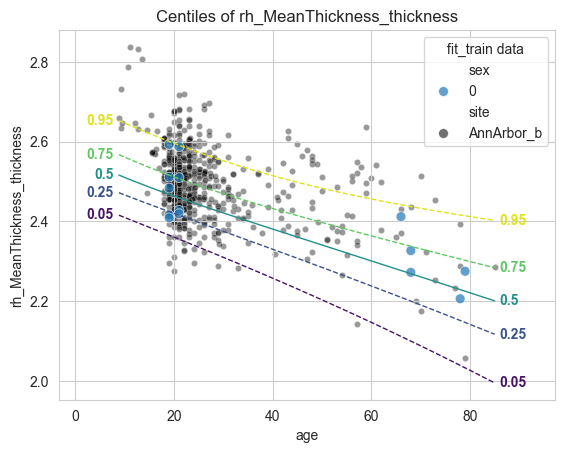

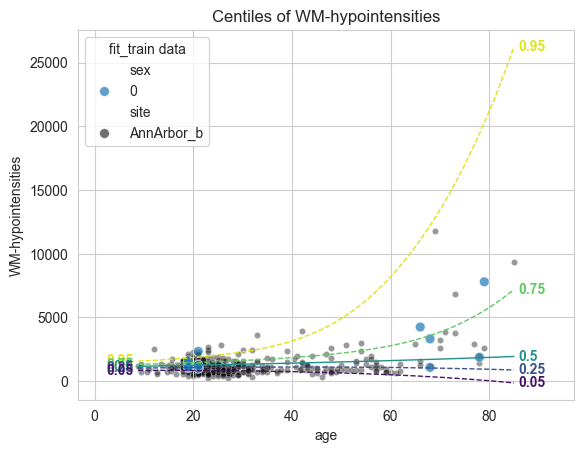

In [24]:
plot_centiles(
    norm_blr,
    train,
    covariate="age",
    show_data=True,
    hue_data="sex",
    markers_data="site",
)

The values of 0.1587 and 0.8413 correspond to a standard deviation of -1 and 1. We plot the centiles again for these values, and we also highlight a specific site. 


Computing centiles for rh_MeanThickness_thickness
Computing centiles for WM-hypointensities


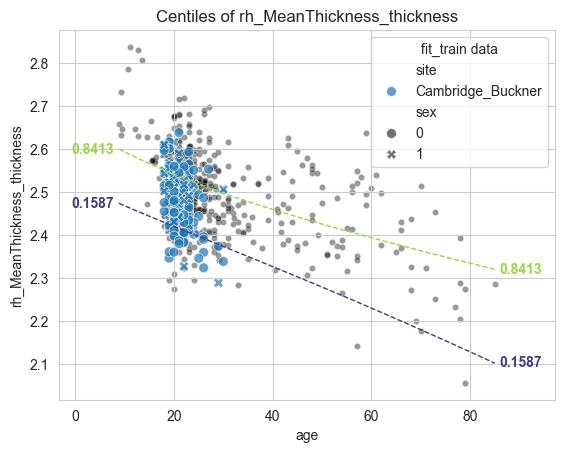

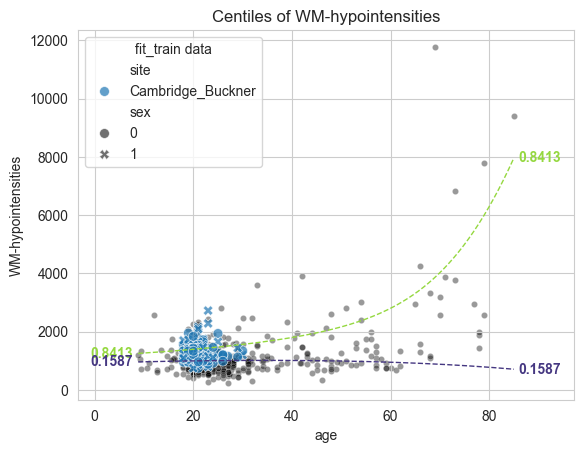

In [25]:
plot_centiles(
    norm_blr,
    train,
    covariate="age",
    cummul_densities=[0.1587, 0.8413],
    show_data=True,
    batch_effects={"site": ["Cambridge_Buckner"]},
)

And that's it, now you have seen how to:
- Use the NormData class to load in your data
- Create and fit a normative model
- Get the evaluation statistics, and create some useful plots

We hope this tutorial was useful. If you have any questions or remarks, please let us know on GitHub. Thanks!